In [1]:
# %gui qt
from collections import defaultdict
import numpy as np
# from mayavi import mlab
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

from kifmm_py import (
    KiFmm,
    LaplaceKernel,
    SingleNodeTree,
    EvalType,
    BlasFieldTranslation,
    FftFieldTranslation,
    read_stl_triangle_mesh_vertices,
)

In [2]:
(sources, faces) = read_stl_triangle_mesh_vertices("battleship.STL")
x = sources[:, 0]
y = sources[:, 1]
z = sources[:, 2]

In [3]:
# mlab.view(azimuth=40, elevation=70, distance="auto", focalpoint="auto")
# fig = mlab.figure(
#     size=(960, 1080), bgcolor=(1, 1, 1)
# )  # This sets the window size for rendering
# plot = mlab.triangular_mesh(
#     x, y, z, faces, color=(0.5, 0.5, 0.5), representation="points", figure=fig
# )
# mlab.show()

In [4]:
dtype = np.float64

# Set FMM Parameters
n_sources = sources.shape[0]
n_targets = sources.shape[0]
eval_type = EvalType.Value
direct = np.zeros(n_sources)

kernel = LaplaceKernel(dtype, eval_type)

sources_flattened = sources.flatten().astype(dtype)
charges = np.ones(n_sources).astype(dtype)

#### FFT-M2L

In [19]:
# expansion_order = np.array([10])
# n_crit = 15
depth = 5
expansion_order = np.array([10 for _ in range(depth+1)])

field_translation = FftFieldTranslation(
    kernel,
    block_size=32   
)
# tree = SingleNodeTree(sources_flattened, sources_flattened, charges, n_crit=n_crit, prune_empty=True)
tree = SingleNodeTree(sources_flattened, sources_flattened, charges, depth=depth, prune_empty=True)

fmm = KiFmm(expansion_order, tree, field_translation, timed=True)

s = time.time()
fmm.evaluate()
print(f'runtime {time.time()-s}')

runtime 5.925027132034302


In [6]:
fmm.leaves_source_tree.shape

(2184,)

In [7]:
# Direct
# fmm.evaluate_kernel_mt(eval_type, sources_flattened, sources_flattened, charges, direct)

In [8]:
# Error
# l2 = lambda fmm, direct: print(np.sum(np.abs(fmm.all_potentials_u[0][:, 0] - direct))/np.sum(np.abs(direct)))

In [9]:
# FFT-M2L error
# l2(fmm, direct)

In [10]:
# e_vec = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
# threshold_vec = [1e-9, 1e-11, 1e-13, 1e-15, 1e-9, 1e-11, 1e-13, 1e-15]
# diff_vec = [0, 0, 0, 0, 1, 1, 1, 1]

# for (expansion_order, threshold, surface_diff) in zip(e_vec, threshold_vec, diff_vec):
#     # n_crit = 15
#     # field_translation = BlasFieldTranslation(
#     #     kernel,
#     #     svd_threshold=dtype(threshold),
#     #     surface_diff=surface_diff,
#     #     random=True,
#     #     n_oversamples=20,
#     # )
#     # tree = SingleNodeTree(sources_flattened, sources_flattened, charges, n_crit=n_crit, prune_empty=True)
#     # s = time.time()
#     # fmm = KiFmm(np.array([expansion_order]), tree, field_translation, timed=True)
#     # print(f'setup took {time.time()-s}')
    
#     depth = 5
#     field_translation = BlasFieldTranslation(
#         kernel,
#         svd_threshold=dtype(threshold),
#         surface_diff=surface_diff,
#         random=True,
#         n_oversamples=20,
#     )
#     tree = SingleNodeTree(sources_flattened, sources_flattened, charges, depth=depth, prune_empty=True)
#     s = time.time()
#     fmm = KiFmm(np.array([expansion_order for _ in range(depth+1)]), tree, field_translation, timed=True)
#     print(f'setup took {time.time()-s}')

#     s = time.time()
#     fmm.evaluate()
#     print(f'order {expansion_order} threshold {threshold} surface_diff {surface_diff } runtime {time.time()-s}')
#     print()

#     # Error
#     l2(fmm, direct)

In [13]:
# n_crit = 15
# field_translation = BlasFieldTranslation(
#         kernel,
#         svd_threshold=dtype(1e-11),
#         surface_diff=1,
#         random=True,
#         n_oversamples=20,
# )
# tree = SingleNodeTree(sources_flattened, sources_flattened, charges, n_crit=n_crit, prune_empty=True)
# s = time.time()
# fmm = KiFmm(np.array([10]), tree, field_translation, timed=True)
# print(f'setup took {time.time()-s}')

depth = 5
expansion_order = np.array([10 for _ in range(depth + 1)])
threshold = 1e-11
surface_diff = 1

field_translation = BlasFieldTranslation(
        kernel,
        svd_threshold=dtype(threshold),
        surface_diff=surface_diff,
        random=True,
        n_oversamples=20,
)
tree = SingleNodeTree(sources_flattened, sources_flattened, charges, depth=depth, prune_empty=True)
s = time.time()
fmm = KiFmm(expansion_order, tree, field_translation, timed=True)
print(f'setup took {time.time()-s}')

s = time.time()
fmm.evaluate()
print(f'order {expansion_order} threshold {threshold} surface_diff {surface_diff } runtime {time.time()-s}')
print()

# # Error
# l2(fmm, direct)

setup took 150.7300660610199
order [10 10 10 10 10 10] threshold 1e-11 surface_diff 1 runtime 5.056733846664429



#### FFT-M2L

In [14]:
dtype = np.float64

# Set FMM Parameters
n_sources = sources.shape[0]
n_targets = sources.shape[0]
eval_type = EvalType.Value
direct = np.zeros(n_sources)

kernel = LaplaceKernel(dtype, eval_type)

uniform = np.random.rand(n_sources, 3)
uniform_flattened = uniform.flatten().astype(dtype)
charges = np.ones(n_sources).astype(dtype)

In [17]:
depth = 4
expansion_order = np.array([10 for _ in range(depth + 1)])

field_translation = FftFieldTranslation(
    kernel,
    block_size=32   
)

tree = SingleNodeTree(uniform_flattened, uniform_flattened, charges, depth=depth, prune_empty=True)
fmm = KiFmm(expansion_order, tree, field_translation, timed=True)

s = time.time()
fmm.evaluate()
print(f'runtime uniform {time.time()-s}')

runtime uniform 3.9333434104919434


#### BLAS-M2L

In [18]:
field_translation = BlasFieldTranslation(
        kernel,
        svd_threshold=dtype(1e-11),
        surface_diff=1,
        random=True,
        n_oversamples=20,
)
tree = SingleNodeTree(uniform_flattened, uniform_flattened, charges, depth=depth, prune_empty=True)
s = time.time()
fmm = KiFmm(expansion_order, tree, field_translation, timed=True)
print(f'setup took {time.time()-s}')

s = time.time()
fmm.evaluate()
print(f'order {expansion_order} threshold {threshold} surface_diff {surface_diff } runtime {time.time()-s}')
print()

# Error
# l2(fmm, direct)

setup took 160.24874591827393
order [10 10 10 10 10] threshold 1e-11 surface_diff 1 runtime 4.74946665763855



# Plot Solution

In [21]:
# mlab.view(azimuth=40, elevation=70, distance="auto", focalpoint="auto")
# fig = mlab.figure(
#     size=(960, 1080), bgcolor=(1, 1, 1)
# )  # This sets the window size for rendering
# solution = mlab.triangular_mesh(
#     x,
#     y,
#     z,
#     faces,
#     scalars=np.log(fmm.all_potentials_u[0][:, 0]),
#     representation="surface",
# )

# colorbar = mlab.colorbar(solution, title="Log-scaled values", orientation="vertical")
# colorbar.title_text_property.font_size = 10
# colorbar.label_text_property.font_size = 8
# mlab.show()

# Statistics

In [22]:
stats = defaultdict(int)

for leaf in fmm.leaves_target_tree:
    found = fmm.coordinates_target_tree(leaf)
    n = found.shape[0]
    stats[n] += 1

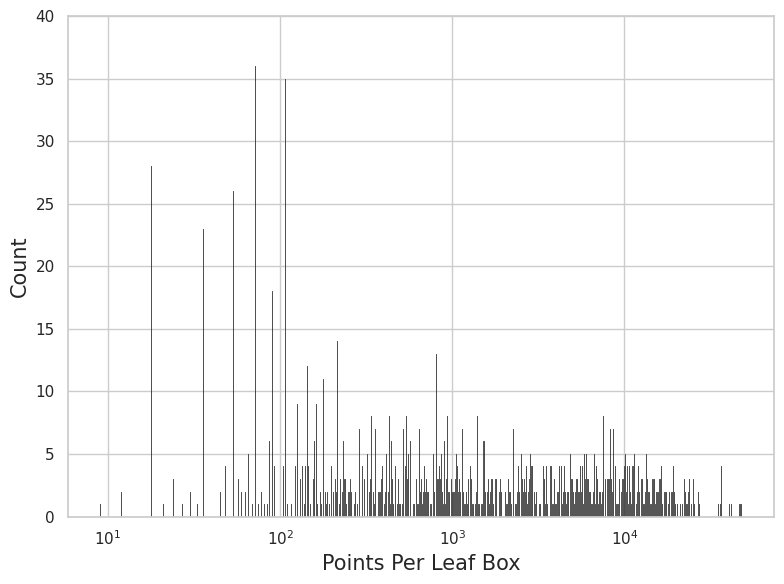

In [37]:
# # Plot the histogram using seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))

# Convert the dictionary to a pandas DataFrame
data = []
for points, occurrences in stats.items():
    data.extend([points] * occurrences)

df = pd.DataFrame(data, columns=["Points"])

hist_plot = sns.histplot(
    df, x="Points", bins=len(stats), color="black", log_scale=(True, False)
)

# # Load CMU font
# import matplotlib.font_manager as fm

# font_path = "/Users/sri/Downloads/cmu/cmunrm.ttf"
# font_properties = fm.FontProperties(fname=font_path)

# hist_plot.set_xlabel("Points Per Leaf Box", fontsize=15, fontproperties=font_properties)
# hist_plot.set_ylabel("Count", fontsize=15, fontproperties=font_properties)

hist_plot.set_xlabel("Points Per Leaf Box", fontsize=15)
hist_plot.set_ylabel("Count", fontsize=15)

hist_plot.set_ybound(lower=None, upper=117)
# Set font properties for tick labels
# for label in hist_plot.get_xticklabels():
    # label.set_fontproperties(font_properties)
# for label in hist_plot.get_yticklabels():
    # label.set_fontproperties(font_properties)

plt.ylim(0, 40)
plt.tight_layout() 
plt.savefig("stats.svg", format="svg")
plt.show()